In [1]:
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import xarray as xr
import glob
import om4labs.om4common as om4
from scipy.stats import t

# parameters for setting circular cutoff for Southern Ocean plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

out_path_fig = '/work/Katherine.Turner/smaller_projects/hifreq-variability/figures/'
out_path_data = '/work/Katherine.Turner/smaller_projects/hifreq-variability/data/'

In [2]:
fpath_idx = '/work/Katherine.Turner/smaller_projects/hifreq-variability/data'

fpath_nc = '/archive/Katherine.Turner/xanadu_mom6_20220703/CM4_piControl_C_restartyear148/gfdl.ncrc5-intel22-prod-openmp/pp'
fpath_stormmmask = '/work/Katherine.Turner/tempest-extremes/odiv-251/comp_wind/v_ref_masked*.nc'

files = {'tos': 'ocean_daily_1x1deg/ts/daily/5yr/*.tos.nc',
         'slp': 'atmos/ts/monthly/5yr/*.slp.nc',
         'u_ref': 'atmos/ts/monthly/5yr/*.u_ref.nc'}

c = {'slp': 1,
     'tos': 1,
     'u_ref': 1}

## High and low years using storm centers

In [13]:
ds_idx = xr.open_dataset(f'{fpath_idx}/CM4_monthly_storms.nc')

idx_summ = ds_idx.center_counts.resample(time='QS-DEC').sum()[4:-4:4] # for djf data
idx_wint = ds_idx.center_counts.resample(time='QS-DEC').sum()[2::4] # for jja data

low_years_summ = idx_summ.sortby(idx_summ).time[:7].dt.year
high_years_summ = idx_summ.sortby(idx_summ).time[-7:].dt.year

low_years_wint = idx_wint.sortby(idx_wint).time[:7].dt.year
high_years_wint = idx_wint.sortby(idx_wint).time[-7:].dt.year

high_years_summ.sortby(high_years_summ).data, low_years_summ.sortby(low_years_summ).data

(array([175, 196, 202, 204, 228, 239, 244]),
 array([176, 192, 205, 212, 213, 224, 225]))

In [14]:
high_years_wint.sortby(high_years_wint).data, low_years_wint.sortby(low_years_wint).data

(array([159, 163, 190, 198, 219, 235, 242]),
 array([167, 197, 207, 220, 225, 228, 245]))

## Storm center counts and distributions

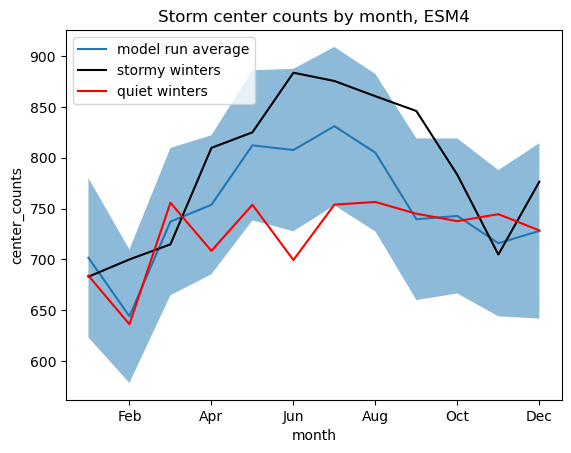

In [129]:
mu = ds_idx.center_counts.groupby(ds_idx.time.dt.month).mean()
std = ds_idx.center_counts.groupby(ds_idx.time.dt.month).std()

#idx_hi = (ds_idx.time.dt.year.isin(high_years2) & ds_idx.time.dt.month.isin([7,8,9,10,11,12])) | (ds_idx.time.dt.year.isin(high_years2 + 1) & ds_idx.time.dt.month.isin([1,2,3,4,5,6]))
#idx_low = (ds_idx.time.dt.year.isin(low_years2) & ds_idx.time.dt.month.isin([7,8,9,10,11,12])) | (ds_idx.time.dt.year.isin(low_years2 + 1) & ds_idx.time.dt.month.isin([1,2,3,4,5,6]))

#idx_hi = ds_idx.time.dt.year.isin(high_years2)
#idx_low = ds_idx.time.dt.year.isin(low_years2)

mu_hi = ds_idx.center_counts[idx_hi].groupby(ds_idx.time[idx_hi].dt.month).mean()
mu_low = ds_idx.center_counts[idx_low].groupby(ds_idx.time[idx_low].dt.month).mean()

fig, axs = plt.subplots()
mu.plot(label='model run average')
axs.fill_between(range(1,13), (mu - std), (mu + std), alpha= 0.5)

mu_hi.plot(color='k', label='stormy winters')
mu_low.plot(color='r', label='quiet winters')

plt.legend()
plt.title(f'Storm center counts by month, {mod}')

axs.set_xticks(np.arange(2,13,2))
axs.set_xticklabels(['Feb', 'Apr', 'Jun', 'Aug', 'Oct', 'Dec'])

plt.savefig(f'/work/Katherine.Turner/smaller_projects/hifreq-variability/figures/storm_centers_6mowinter_{mod}.png', 
            format='png', 
            dpi=100)

In [18]:
ds_mask = xr.open_mfdataset(fpath_stormmmask[mod],use_cftime=True)

mask_monthly = 0.25 * ds_mask.mask.resample(time='M').sum()
mask_monthly = mask_monthly.compute()
mask_monthly.to_dataset(name='mask_monthly').to_netcdf(f'/work/Katherine.Turner/smaller_projects/hifreq-variability/data/{mod}_monthly_mask.nc')

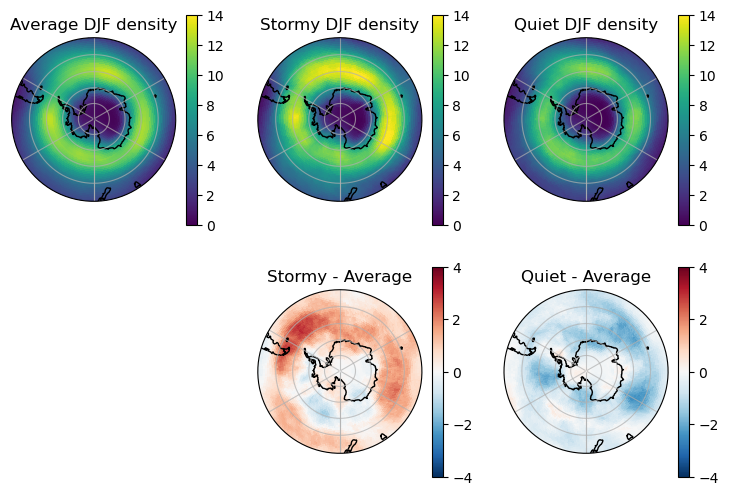

In [40]:
ds_mask = xr.open_mfdataset(f'/work/Katherine.Turner/smaller_projects/hifreq-variability/data/{mod}_monthly_mask.nc',use_cftime=True)
mask_monthly = ds_mask.mask_monthly

#for summers where we have to skip over the years
idx_djf = mask_monthly.time.dt.month.isin([12,1,2])
idx_hi = (mask_monthly.time.dt.year.isin(high_years) & mask_monthly.time.dt.month.isin([12])) | (mask_monthly.time.dt.year.isin(high_years + 1) & mask_monthly.time.dt.month.isin([1,2]))
idx_low = (mask_monthly.time.dt.year.isin(low_years) & mask_monthly.time.dt.month.isin([12])) | (mask_monthly.time.dt.year.isin(low_years + 1) & mask_monthly.time.dt.month.isin([1,2]))

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(9,6),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})

axs = axs.flatten()

mask_monthly[idx_djf,:,:].mean(dim='time').plot(ax=axs[0], 
                                                transform=ccrs.PlateCarree(),
                                                vmin=0, vmax=14, extend='neither',
                                                cbar_kwargs={'label':''})
axs[0].set_title('Average DJF density')

mask_monthly[idx_hi,:,:].mean(dim='time').plot(ax=axs[1],
                                               transform=ccrs.PlateCarree(),
                                               vmin=0, vmax=14, extend='neither',
                                               cbar_kwargs={'label':''})
axs[1].set_title('Stormy DJF density')

mask_monthly[idx_low,:,:].mean(dim='time').plot(ax=axs[2],
                                                transform=ccrs.PlateCarree(),
                                                vmin=0, vmax=14, extend='neither',
                                                cbar_kwargs={'label':''})
axs[2].set_title('Quiet DJF density')

(mask_monthly[idx_hi,:,:].mean(dim='time') - mask_monthly[idx_djf,:,:].mean(dim='time')).plot(ax=axs[4], 
                                                                                              transform=ccrs.PlateCarree(),
                                                                                              vmin=-4, vmax=4, extend='neither',
                                                                                              cmap='RdBu_r',
                                                                                              cbar_kwargs={'label':''})
axs[4].set_title('Stormy - Average')

(mask_monthly[idx_low,:,:].mean(dim='time') - mask_monthly[idx_djf,:,:].mean(dim='time')).plot(ax=axs[5], 
                                                                                               transform=ccrs.PlateCarree(),
                                                                                               vmin=-4, vmax=4, extend='neither',
                                                                                               cmap='RdBu_r',
                                                                                               cbar_kwargs={'label':''})
axs[5].set_title('Quiet - Average')

for i in range(6):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()

axs[3].remove()

plt.savefig(f'/work/Katherine.Turner/smaller_projects/hifreq-variability/figures/storm_activity_djf_{mod}.png', 
            format='png', 
            dpi=100)

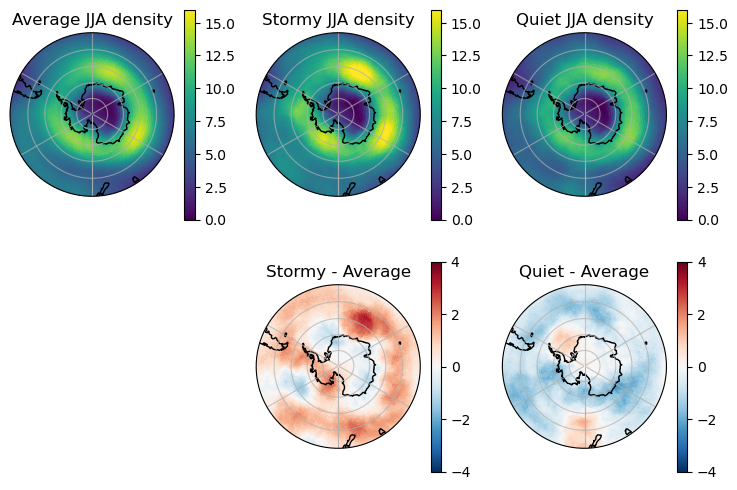

In [54]:
ds_mask = xr.open_mfdataset(f'/work/Katherine.Turner/smaller_projects/hifreq-variability/data/{mod}_monthly_mask.nc',use_cftime=True)
mask_monthly = ds_mask.mask_monthly

idx_jja = mask_monthly.time.dt.month.isin([6,7,8])
idx_hi = mask_monthly.time.dt.year.isin(high_years) & idx_jja
idx_low = mask_monthly.time.dt.year.isin(low_years) & idx_jja

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(9,6),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})

axs = axs.flatten()

mask_monthly[idx_jja,:,:].mean(dim='time').plot(ax=axs[0], 
                                                transform=ccrs.PlateCarree(),
                                                vmin=0, vmax=16, extend='neither',
                                                cbar_kwargs={'label':''})
axs[0].set_title('Average JJA density')

mask_monthly[idx_hi,:,:].mean(dim='time').plot(ax=axs[1],
                                               transform=ccrs.PlateCarree(),
                                               vmin=0, vmax=16, extend='neither',
                                               cbar_kwargs={'label':''})
axs[1].set_title('Stormy JJA density')

mask_monthly[idx_low,:,:].mean(dim='time').plot(ax=axs[2],
                                                transform=ccrs.PlateCarree(),
                                                vmin=0, vmax=16, extend='neither',
                                                cbar_kwargs={'label':''})
axs[2].set_title('Quiet JJA density')

(mask_monthly[idx_hi,:,:].mean(dim='time') - mask_monthly[idx_jja,:,:].mean(dim='time')).plot(ax=axs[4], 
                                                                                              transform=ccrs.PlateCarree(),
                                                                                              vmin=-4, vmax=4, extend='neither',
                                                                                              cmap='RdBu_r',
                                                                                              cbar_kwargs={'label':''})
axs[4].set_title('Stormy - Average')

(mask_monthly[idx_low,:,:].mean(dim='time') - mask_monthly[idx_jja,:,:].mean(dim='time')).plot(ax=axs[5], 
                                                                                               transform=ccrs.PlateCarree(),
                                                                                               vmin=-4, vmax=4, extend='neither',
                                                                                               cmap='RdBu_r',
                                                                                               cbar_kwargs={'label':''})
axs[5].set_title('Quiet - Average')

for i in range(6):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()

axs[3].remove()

plt.savefig(f'/work/Katherine.Turner/smaller_projects/hifreq-variability/figures/storm_activity_jja_{mod}.png', 
            format='png', 
            dpi=100)

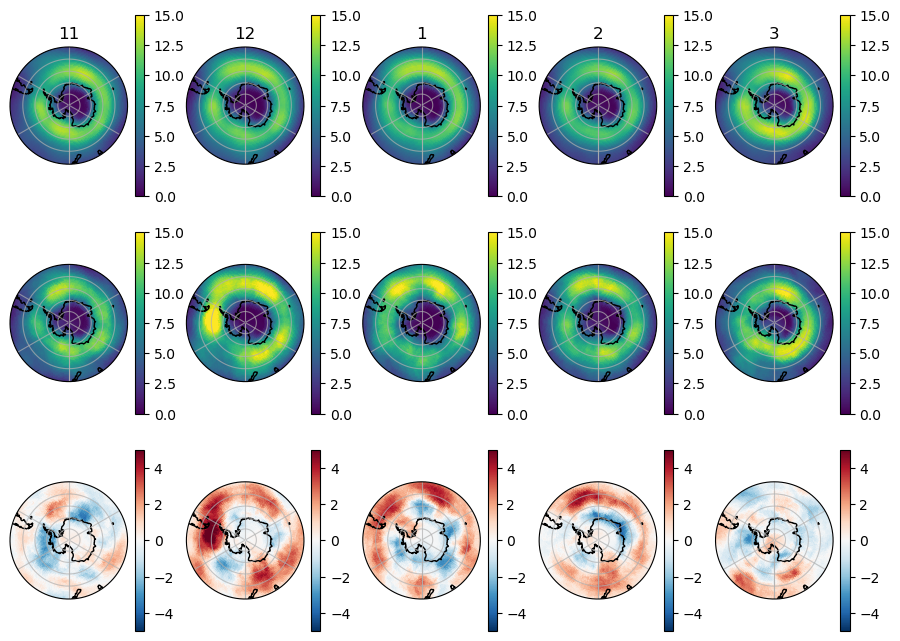

In [31]:
ds_mask = xr.open_mfdataset(f'/work/Katherine.Turner/smaller_projects/hifreq-variability/data/{mod}_monthly_mask.nc',use_cftime=True)
mask_monthly = ds_mask.mask_monthly

#for summers where we have to skip over the years
idx_hi = (mask_monthly.time.dt.year.isin(high_years) & mask_monthly.time.dt.month.isin([7,8,9,10,11,12])) | (mask_monthly.time.dt.year.isin(high_years + 1) & mask_monthly.time.dt.month.isin([1,2,3,4,5,6]))
idx_low = (mask_monthly.time.dt.year.isin(low_years) & mask_monthly.time.dt.month.isin([7,8,9,10,11,12])) | (mask_monthly.time.dt.year.isin(low_years + 1) & mask_monthly.time.dt.month.isin([1,2,3,4,5,6]))

#idx_hi = mask_monthly.time.dt.year.isin(high_years)
#idx_low = mask_monthly.time.dt.year.isin(low_years)

fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(11,8),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})

summ_months = np.arange(10,10+5) % 12 + 1
wint_months = np.arange(5,10)

for i, mon in enumerate(summ_months):
    idx_month = mask_monthly.time.dt.month == mon
    
    mask_monthly[idx_month,:,:].mean(dim='time').plot(ax=axs[0][i], x='lon', y='lat', 
                                                      vmin=0, vmax=15,
                                                      extend='neither',
                                                      transform=ccrs.PlateCarree(),
                                                      cbar_kwargs={'label':''})
    axs[0][i].set_title(mon)
    
    mask_monthly[idx_month & idx_hi,:,:].mean(dim='time').plot(ax=axs[1][i], x='lon', y='lat', 
                                                               transform=ccrs.PlateCarree(),
                                                               vmin=0, vmax=15,
                                                               extend='neither',
                                                               cbar_kwargs={'label':''})
    
    (mask_monthly[idx_month & idx_hi,:,:].mean(dim='time') - mask_monthly[idx_month,:,:].mean(dim='time')).plot(ax=axs[2][i], 
                                                                                                                x='lon', y='lat', 
                                                                                                                transform=ccrs.PlateCarree(),
                                                                                                                vmin=-5, vmax=5,
                                                                                                                extend='neither',
                                                                                                                cmap='RdBu_r',
                                                                                                                cbar_kwargs={'label':''})
    
    for j in range(3):
        axs[j][i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
        axs[j][i].gridlines(alpha=0.7)
        axs[j][i].set_boundary(circle, transform=axs[j][i].transAxes)
        axs[j][i].coastlines()
        
plt.savefig(f'/work/Katherine.Turner/smaller_projects/hifreq-variability/figures/storm_activity_5mosummer_{mod}_high.png', 
            format='png', 
            dpi=100)

## SLP composites

In [16]:
var = 'slp'
ds = xr.open_mfdataset(f'{fpath_nc}/{files[var]}', use_cftime=True)

da_summ = (c[var] * ds[var]).resample(time='QS-DEC').mean()[::4]
da_wint = (c[var] * ds[var]).resample(time='QS-DEC').mean()[2::4]

In [17]:
idx_lo_summ = da_summ.time.dt.year.isin(low_years_summ)
idx_hi_summ = da_summ.time.dt.year.isin(high_years_summ)

d_hi_summ = da_summ[idx_hi_summ,:,:].mean(dim='time') - da_summ.mean(dim='time')
d_lo_summ = da_summ[idx_lo_summ,:,:].mean(dim='time') - da_summ.mean(dim='time')

idx_lo_wint = da_wint.time.dt.year.isin(low_years_wint)
idx_hi_wint = da_wint.time.dt.year.isin(high_years_wint)

d_hi_wint = da_wint[idx_hi_wint,:,:].mean(dim='time') - da_wint.mean(dim='time')
d_lo_wint = da_wint[idx_lo_wint,:,:].mean(dim='time') - da_wint.mean(dim='time')

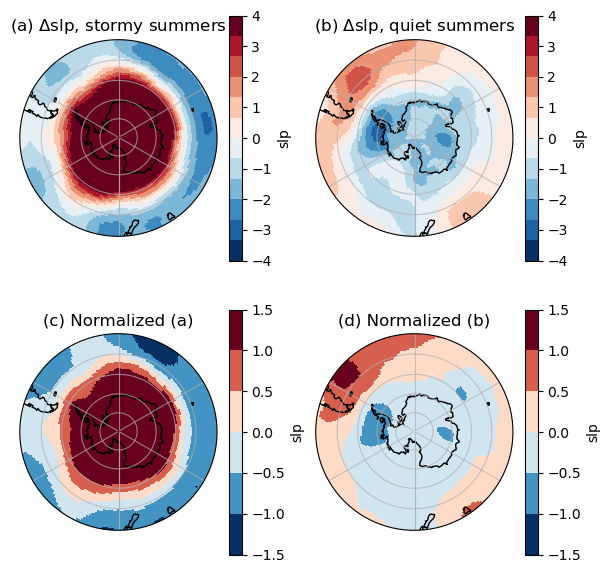

In [18]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                       subplot_kw={'projection': ccrs.SouthPolarStereo()}, 
                       figsize=(7,7))
axs=axs.flatten()


d_hi_summ.plot(ax=axs[0], transform=ccrs.PlateCarree(),
          vmax=4, vmin=-4, extend='neither',
          cmap=plt.get_cmap('RdBu_r', 12)
         )

d_lo_summ.plot(ax=axs[1], transform=ccrs.PlateCarree(),
          vmax=4, vmin=-4, extend='neither',
          cmap=plt.get_cmap('RdBu_r', 12)
         )

(d_hi_summ/da_summ.std(dim='time')).plot(ax=axs[2], transform=ccrs.PlateCarree(), 
                                         vmax=1.5, vmin=-1.5,
                                         extend='neither',
                                         cmap=plt.get_cmap('RdBu_r', 6)
                                        )

(d_lo_summ/da_summ.std(dim='time')).plot(ax=axs[3], transform=ccrs.PlateCarree(),
                                         vmax=1.5, vmin=-1.5,
                                         extend='neither',
                                         cmap=plt.get_cmap('RdBu_r', 6)
                                        )

axs[0].set_title(f'(a) $\Delta${var}, stormy summers')
axs[1].set_title(f'(b) $\Delta${var}, quiet summers')
axs[2].set_title(f'(c) Normalized (a)')
axs[3].set_title(f'(d) Normalized (b)')


for i in range(4):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()
    
plt.savefig(f'{out_path_fig}comp_{var}_djf_CM4.png', format='png', dpi=100)

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                       subplot_kw={'projection': ccrs.SouthPolarStereo()}, 
                       figsize=(7,7))
axs=axs.flatten()


d_hi_wint.plot(ax=axs[0], transform=ccrs.PlateCarree(),
          vmax=4, vmin=-4, extend='neither',
          cmap=plt.get_cmap('RdBu_r', 12)
         )

d_lo_wint.plot(ax=axs[1], transform=ccrs.PlateCarree(),
          vmax=4, vmin=-4, extend='neither',
          cmap=plt.get_cmap('RdBu_r', 12)
         )

(d_hi_wint/da_wint.std(dim='time')).plot(ax=axs[2], transform=ccrs.PlateCarree(), 
                                         vmax=1.5, vmin=-1.5,
                                         extend='neither',
                                         cmap=plt.get_cmap('RdBu_r', 6)
                                        )

(d_lo_wint/da_wint.std(dim='time')).plot(ax=axs[3], transform=ccrs.PlateCarree(),
                                         vmax=1.5, vmin=-1.5,
                                         extend='neither',
                                         cmap=plt.get_cmap('RdBu_r', 6)
                                        )

axs[0].set_title(f'(a) $\Delta${var}, stormy winters')
axs[1].set_title(f'(b) $\Delta${var}, quiet winters')
axs[2].set_title(f'(c) Normalized (a)')
axs[3].set_title(f'(d) Normalized (b)')


for i in range(4):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()
    
plt.savefig(f'{out_path_fig}comp_{var}_jja_CM4.png', format='png', dpi=100)

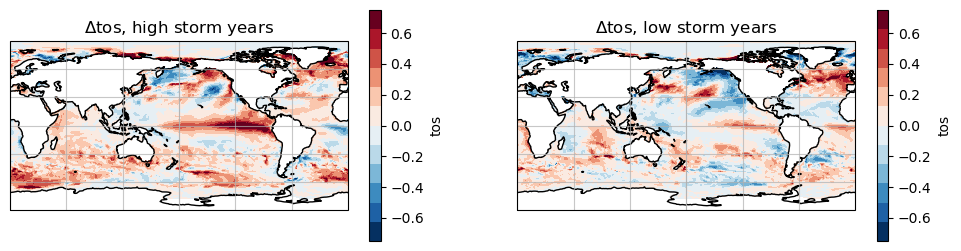

In [44]:
fig, axs = plt.subplots(nrows=1, ncols=2,
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, 
                       figsize=(12,3))
axs=axs.flatten()

(c[var]*(ds[var][idx_hi,:,:].mean(dim='time') - ds[var][idx_jja,:,:].mean(dim='time'))).plot(ax=axs[0], transform=ccrs.PlateCarree(), 
                                                               vmax=.75, vmin=-.75, extend='neither',
                                                               cmap=plt.get_cmap('RdBu_r', 12))

(c[var]*(ds[var][idx_lo,:,:].mean(dim='time') - ds[var][idx_jja,:,:].mean(dim='time'))).plot(ax=axs[1], transform=ccrs.PlateCarree(), 
                                                               vmax=.75, vmin=-.75, extend='neither',
                                                               cmap=plt.get_cmap('RdBu_r', 12))

axs[0].set_title(f'$\Delta${var}, high storm years')
axs[1].set_title(f'$\Delta${var}, low storm years')

for i in range(2):
    axs[i].gridlines(alpha=0.7)
    axs[i].coastlines()
    
plt.savefig(f'/home/Katherine.Turner/Figures/{mod}_stormywint_toscomp_global.png', format='png', dpi=100)

## SST composites

In [20]:
var = 'tos'
ds = xr.open_mfdataset(f'{fpath_nc}/{files[var]}', use_cftime=True)

da_summ = (c[var] * ds[var]).resample(time='QS-DEC').mean()[::4]
da_wint = (c[var] * ds[var]).resample(time='QS-DEC').mean()[2::4]

In [21]:
idx_lo_summ = da_summ.time.dt.year.isin(low_years_summ)
idx_hi_summ = da_summ.time.dt.year.isin(high_years_summ)

d_hi_summ = da_summ[idx_hi_summ,:,:].mean(dim='time') - da_summ.mean(dim='time')
d_lo_summ = da_summ[idx_lo_summ,:,:].mean(dim='time') - da_summ.mean(dim='time')

idx_lo_wint = da_wint.time.dt.year.isin(low_years_wint)
idx_hi_wint = da_wint.time.dt.year.isin(high_years_wint)

d_hi_wint = da_wint[idx_hi_wint,:,:].mean(dim='time') - da_wint.mean(dim='time')
d_lo_wint = da_wint[idx_lo_wint,:,:].mean(dim='time') - da_wint.mean(dim='time')

/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


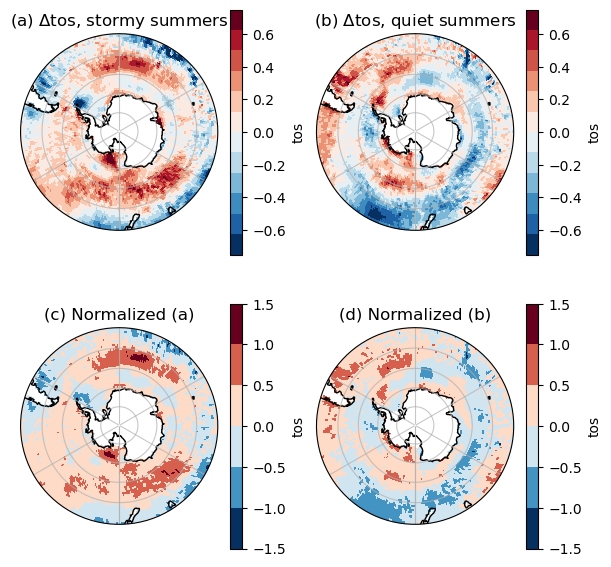

In [22]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                       subplot_kw={'projection': ccrs.SouthPolarStereo()}, 
                       figsize=(7,7))
axs=axs.flatten()


d_hi_summ.plot(ax=axs[0], transform=ccrs.PlateCarree(),
          vmax=.75, vmin=-.75, extend='neither',
          cmap=plt.get_cmap('RdBu_r', 12)
         )

d_lo_summ.plot(ax=axs[1], transform=ccrs.PlateCarree(),
          vmax=.75, vmin=-.75, extend='neither',
          cmap=plt.get_cmap('RdBu_r', 12)
         )

(d_hi_summ/da_summ.std(dim='time')).plot(ax=axs[2], transform=ccrs.PlateCarree(), 
                                         vmax=1.5, vmin=-1.5,
                                         extend='neither',
                                         cmap=plt.get_cmap('RdBu_r', 6)
                                        )

(d_lo_summ/da_summ.std(dim='time')).plot(ax=axs[3], transform=ccrs.PlateCarree(),
                                         vmax=1.5, vmin=-1.5,
                                         extend='neither',
                                         cmap=plt.get_cmap('RdBu_r', 6)
                                        )

axs[0].set_title(f'(a) $\Delta${var}, stormy summers')
axs[1].set_title(f'(b) $\Delta${var}, quiet summers')
axs[2].set_title(f'(c) Normalized (a)')
axs[3].set_title(f'(d) Normalized (b)')


for i in range(4):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()
    
plt.savefig(f'{out_path_fig}comp_{var}_djf_CM4.png', format='png', dpi=100)

/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


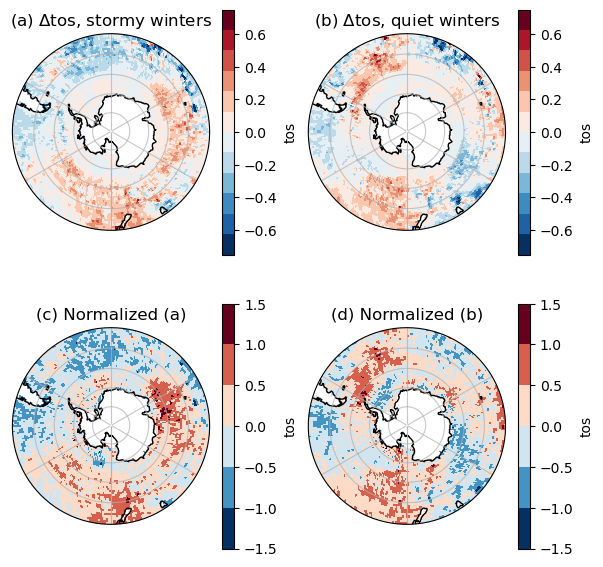

In [24]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                       subplot_kw={'projection': ccrs.SouthPolarStereo()}, 
                       figsize=(7,7))
axs=axs.flatten()


d_hi_wint.plot(ax=axs[0], transform=ccrs.PlateCarree(),
          vmax=.75, vmin=-.75, extend='neither',
          cmap=plt.get_cmap('RdBu_r', 12)
         )

d_lo_wint.plot(ax=axs[1], transform=ccrs.PlateCarree(),
          vmax=.75, vmin=-.75, extend='neither',
          cmap=plt.get_cmap('RdBu_r', 12)
         )

(d_hi_wint/da_wint.std(dim='time')).plot(ax=axs[2], transform=ccrs.PlateCarree(), 
                                         vmax=1.5, vmin=-1.5,
                                         extend='neither',
                                         cmap=plt.get_cmap('RdBu_r', 6)
                                        )

(d_lo_wint/da_wint.std(dim='time')).plot(ax=axs[3], transform=ccrs.PlateCarree(),
                                         vmax=1.5, vmin=-1.5,
                                         extend='neither',
                                         cmap=plt.get_cmap('RdBu_r', 6)
                                        )

axs[0].set_title(f'(a) $\Delta${var}, stormy winters')
axs[1].set_title(f'(b) $\Delta${var}, quiet winters')
axs[2].set_title(f'(c) Normalized (a)')
axs[3].set_title(f'(d) Normalized (b)')


for i in range(4):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()
    
plt.savefig(f'{out_path_fig}comp_{var}_jja_CM4.png', format='png', dpi=100)

## 500 mbar geopotential height

In [45]:
var = 'Z500'
ds = xr.open_mfdataset(f'{out_path_data}/CM4/*z500.nc', use_cftime=True)

In [46]:
da_summ = ds[var].resample(time='QS-DEC').mean()[::4]
da_wint = ds[var].resample(time='QS-DEC').mean()[2::4]

In [47]:
idx_lo_summ = da_summ.time.dt.year.isin(low_years_summ)
idx_hi_summ = da_summ.time.dt.year.isin(high_years_summ)

d_hi_summ = da_summ[idx_hi_summ,:,:].mean(dim='time') - da_summ.mean(dim='time')
d_lo_summ = da_summ[idx_lo_summ,:,:].mean(dim='time') - da_summ.mean(dim='time')

idx_lo_wint = da_wint.time.dt.year.isin(low_years_wint)
idx_hi_wint = da_wint.time.dt.year.isin(high_years_wint)

d_hi_wint = da_wint[idx_hi_wint,:,:].mean(dim='time') - da_wint.mean(dim='time')
d_lo_wint = da_wint[idx_lo_wint,:,:].mean(dim='time') - da_wint.mean(dim='time')

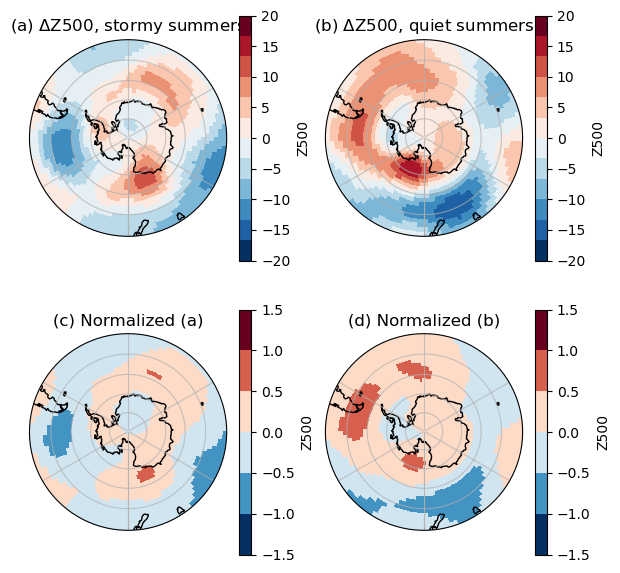

In [49]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                       subplot_kw={'projection': ccrs.SouthPolarStereo()}, 
                       figsize=(7,7))
axs=axs.flatten()


d_hi_summ.plot(ax=axs[0], transform=ccrs.PlateCarree(),
          vmax=20, vmin=-20, extend='neither',
          cmap=plt.get_cmap('RdBu_r', 12)
         )

d_lo_summ.plot(ax=axs[1], transform=ccrs.PlateCarree(),
          vmax=20, vmin=-20, extend='neither',
          cmap=plt.get_cmap('RdBu_r', 12)
         )

(d_hi_summ/da_summ.std(dim='time')).plot(ax=axs[2], transform=ccrs.PlateCarree(), 
                                         vmax=1.5, vmin=-1.5,
                                         extend='neither',
                                         cmap=plt.get_cmap('RdBu_r', 6)
                                        )

(d_lo_summ/da_summ.std(dim='time')).plot(ax=axs[3], transform=ccrs.PlateCarree(),
                                         vmax=1.5, vmin=-1.5,
                                         extend='neither',
                                         cmap=plt.get_cmap('RdBu_r', 6)
                                        )

axs[0].set_title(f'(a) $\Delta${var}, stormy summers')
axs[1].set_title(f'(b) $\Delta${var}, quiet summers')
axs[2].set_title(f'(c) Normalized (a)')
axs[3].set_title(f'(d) Normalized (b)')


for i in range(4):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()
    
plt.savefig(f'{out_path_fig}comp_{var}_djf_CM4.png', format='png', dpi=100)

/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


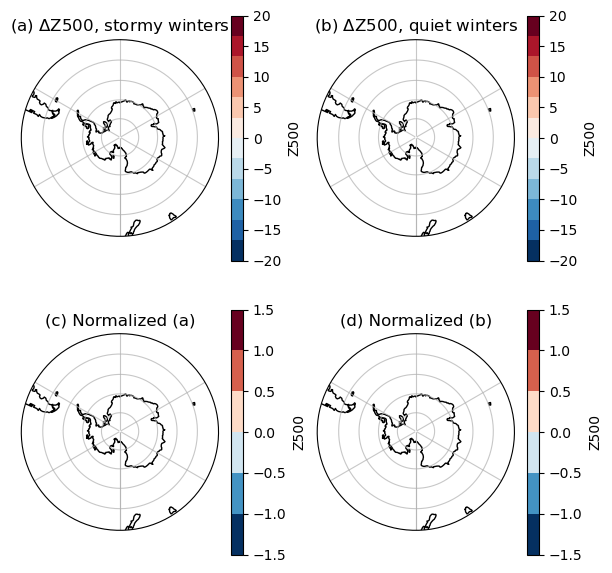

In [50]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                       subplot_kw={'projection': ccrs.SouthPolarStereo()}, 
                       figsize=(7,7))
axs=axs.flatten()


d_hi_wint.plot(ax=axs[0], transform=ccrs.PlateCarree(),
          vmax=20, vmin=-20, extend='neither',
          cmap=plt.get_cmap('RdBu_r', 12)
         )

d_lo_wint.plot(ax=axs[1], transform=ccrs.PlateCarree(),
          vmax=20, vmin=-20, extend='neither',
          cmap=plt.get_cmap('RdBu_r', 12)
         )

(d_hi_wint/da_wint.std(dim='time')).plot(ax=axs[2], transform=ccrs.PlateCarree(), 
                                         vmax=1.5, vmin=-1.5,
                                         extend='neither',
                                         cmap=plt.get_cmap('RdBu_r', 6)
                                        )

(d_lo_wint/da_wint.std(dim='time')).plot(ax=axs[3], transform=ccrs.PlateCarree(),
                                         vmax=1.5, vmin=-1.5,
                                         extend='neither',
                                         cmap=plt.get_cmap('RdBu_r', 6)
                                        )

axs[0].set_title(f'(a) $\Delta${var}, stormy winters')
axs[1].set_title(f'(b) $\Delta${var}, quiet winters')
axs[2].set_title(f'(c) Normalized (a)')
axs[3].set_title(f'(d) Normalized (b)')


for i in range(4):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()
    
plt.savefig(f'{out_path_fig}comp_{var}_jja_CM4.png', format='png', dpi=100)

In [54]:
ds

<xarray.Dataset>
Dimensions:  (lat: 90, lon: 144, time: 95)
Coordinates:
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * time     (time) object 0151-12-31 00:00:00 ... 0245-12-31 00:00:00
Data variables:
    Z500     (time, lat, lon) float32 dask.array<chunksize=(5, 90, 144), meta=np.ndarray>